# GANs con redes dense

In [15]:
# Importamos la librerías
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras import optimizers, backend
from tensorflow.keras.datasets import mnist

In [16]:
backend.clear_session()

## Red generadora

In [17]:
# Generador
generador = Sequential()
generador.add(Dense(100, input_shape = (20,)))
generador.add(LeakyReLU(alpha = 0.3))
generador.add(Dense(300))
generador.add(Dense(784, activation = 'tanh'))
generador.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2100      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               30300     
                                                                 
 dense_2 (Dense)             (None, 784)               235984    
                                                                 
Total params: 268384 (1.02 MB)
Trainable params: 268384 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Red discriminativa

In [18]:
# Discriminador
discriminador = Sequential()
discriminador.add(Dense(300, input_shape = (784,)))
discriminador.add(LeakyReLU(alpha = 0.3))
discriminador.add(Dense(100))
discriminador.add(LeakyReLU(alpha = 0.3))
discriminador.add(Dense(1, activation = 'sigmoid'))
discriminador.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 265701 (1.01 MB)
Trainable params: 265701 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Red GAN

In [19]:
# Como el discriminador se entrena por separado, se compila aparte
adam_1 = optimizers.Adam(learning_rate = 0.001)
discriminador.compile(loss = 'binary_crossentropy', optimizer = adam_1, metrics = ['accuracy'])

In [20]:
# Como el generador se entrena junto con la red discriminativa se crea un modelo nuevo para
# juntar las dos redes

# Se "congela" la red discriminativa
discriminador.trainable = False

# Definimos el modelo GAN con el generador y el discriminador
gan = Sequential()
gan.add(generador)
gan.add(discriminador)

In [21]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 784)               268384    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 265701    
                                                                 
Total params: 534085 (2.04 MB)
Trainable params: 268384 (1.02 MB)
Non-trainable params: 265701 (1.01 MB)
_________________________________________________________________


In [22]:
# Compilamos el modelo GAN
adam_2 = optimizers.Adam(learning_rate = 0.001)
gan.compile(loss = 'binary_crossentropy', optimizer = adam_2)

## Preprocesamiento de las imágenes

In [23]:
# Preparación de las imagenes de entrenamiento
(x_train, _), (_, _) = mnist.load_data()

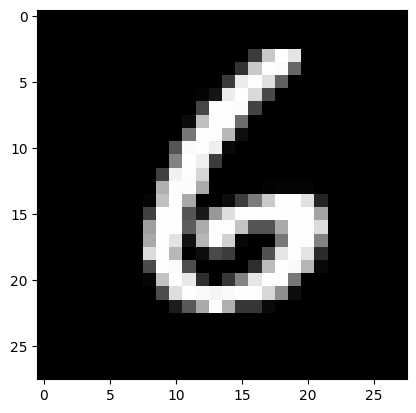

In [24]:
# Visualización de las imágenes de entrenamiento
n_img = 6000
plt.imshow(x_train[n_img], cmap='gray')
plt.show()

In [25]:
# Aplanamiento
x_train = x_train.reshape(60000, 784)
# Normalización
x_train = x_train/255

## Funciones auxiliares

In [26]:
# La siguiente función selecciona imágenes de forma aleatoria del conjunto de entrenamiento x_train
def genera_ejemplos_reales(dataset, n_muestras):
  indices = np.random.randint(0, dataset.shape[0], n_muestras)
  x = dataset[indices]
  y = np.ones((n_muestras, 1))
  return x,y

In [27]:
# La siguiente función genera vectores latentes con valores aleatorios de una distribución normal
def genera_vectores_latentes(dimension, n_muestras):
  z = np.random.randn(n_muestras, dimension)
  return z

In [28]:
# La siguiente función genera imágenes falsas a partir de vectores latentes
def genera_ejemplos_falsos(gen_model, latent_dim, n_muestras):
  z = genera_vectores_latentes(latent_dim, n_muestras)
  x_pred = gen_model.predict(z)
  y_pred = np.zeros((n_muestras,1))
  return x_pred, y_pred

In [29]:
# La siguiente función calcula la precisión en la clasificación de imagenes reales y falsas
def performance_discriminador(gen_model, disc_model, dataset, latent_dim, n_muestras = 100):
  x_real, y_real = genera_ejemplos_reales(dataset, n_muestras)
  loss_real, acc_real = disc_model.evaluate(x_real, y_real, verbose = False)
  x_falso, y_falso = genera_ejemplos_falsos(gen_model, latent_dim, n_muestras)
  loss_falso, acc_falso = disc_model.evaluate(x_falso, y_falso, verbose = False)
  return acc_real, acc_falso

In [30]:
# Función para entrenar los modelos generativo y discriminativo
def train(gen_model, disc_model, gan_model, dataset, latent_dim, n_epochs, n_batch=256):
  batch_per_epo = int(dataset.shape[0]/ n_batch)
  hist = []
  for i in range(n_epochs):
    for j in range(batch_per_epo):
      # Seleccionamos imágenes reales
      x_real, y_real = genera_ejemplos_reales(dataset, int(n_batch/2))
      # Creamos imagenes falsas
      x_falso, y_falso = genera_ejemplos_falsos(gen_model, latent_dim, int(n_batch/2))
      # Concatenamos las imágenes y etiquetas
      x = np.concatenate((x_real, x_falso))
      y = np.concatenate((y_real, y_falso))
      # Entrenamos el discriminador con las imágenes reales y falsas
      disc_model.trainable = True
      d_loss, _ = disc_model.train_on_batch(x, y)
      # Generamos vectores latentes
      x_gan = genera_vectores_latentes(latent_dim, n_batch)
      # Generamos etiquetas para imágenes 'reales'
      y_gan = np.ones((n_batch, 1))
      # Entrenamos el generador con la red discriminativa congelada
      disc_model.trainable = False
      g_loss = gan_model.train_on_batch(x_gan, y_gan)

    if i%5 == 0:
      d_acc_real, d_acc_falso = performance_discriminador(gen_model, disc_model, dataset, latent_dim)
      print('epoca = ', i, 'g_loss', g_loss)
      print('d_acc_real = ', d_acc_real, 'd_acc_falso = ', d_acc_falso)
    hist.append([d_acc_real, d_acc_falso, g_loss])
  return hist

1/1 [==============================] - 0s 265ms/step


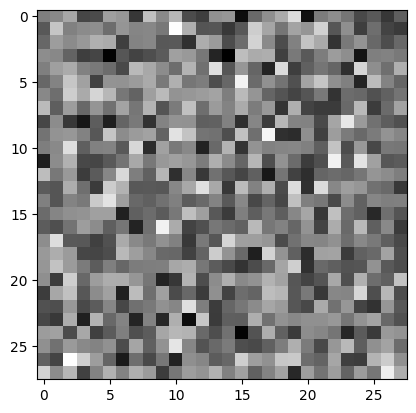

In [31]:
# Prueba antes del entrenamiento
x_nuevo, y_nuevo = genera_ejemplos_falsos(generador, 20, 1)
# Visualización
plt.imshow(x_nuevo.reshape(28,28), cmap='gray')
plt.show()

In [32]:
# Entrenamiento
latent_dimension = 20
epocas = 20
discriminador.trainable = True   # no es necesario por el
H = train(generador, discriminador, gan, x_train, latent_dimension, epocas)

4/4 [==============================] - 0s 13ms/step
epoca =  0 g_loss 12.382686614990234
d_acc_real =  0.6600000262260437 d_acc_falso =  0.3700000047683716
4/4 [==============================] - 0s 3ms/step
epoca =  5 g_loss 8.952398300170898
d_acc_real =  0.9100000262260437 d_acc_falso =  0.7699999809265137
4/4 [==============================] - 0s 3ms/step
epoca =  10 g_loss 2.5859427452087402
d_acc_real =  0.6499999761581421 d_acc_falso =  0.6800000071525574
4/4 [==============================] - 0s 3ms/step
epoca =  15 g_loss 1.7874345779418945
d_acc_real =  0.8799999952316284 d_acc_falso =  0.7300000190734863
4/4 [==============================] - 0s 3ms/step


## Evaluación

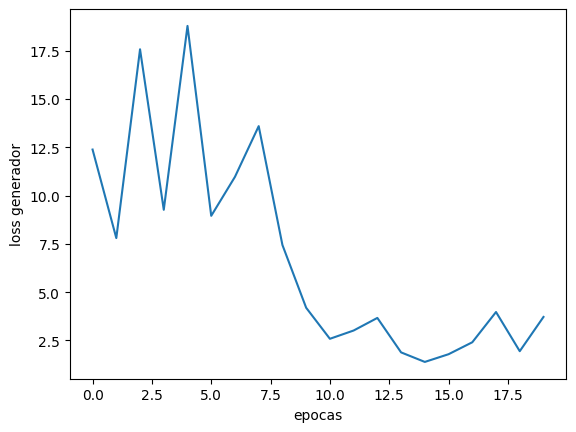

In [33]:
H = np.array(H)
plt.plot(H[:, 2])
plt.xlabel('epocas')
plt.ylabel('loss generador')
plt.show()

## Pruebas del generador

1/1 [==============================] - 0s 25ms/step


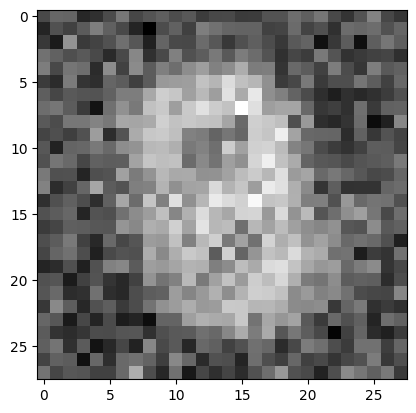

In [36]:
# Generamos imágenes falsas
x_nuevo, y_nuevo = genera_ejemplos_falsos(generador, 20, 1)

plt.imshow(x_nuevo.reshape(28, 28), cmap = 'gray')
plt.show()

In [ ]:
# # Visualización
# x_nuevo =
# plt.imshow(    , cmap='gray')
# plt.show()

1/1 [==============================] - 0s 21ms/step


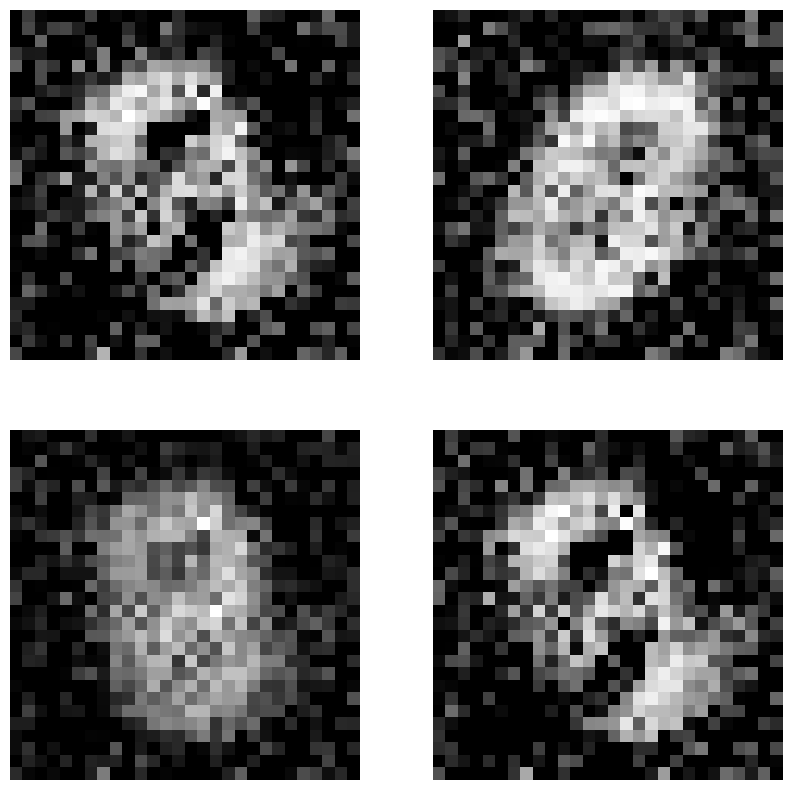

In [43]:
x_nuevo, y_nuevo = genera_ejemplos_falsos(generador, latent_dimension, 4)
plt.figure(figsize=(10,10))
for i in range(x_nuevo.shape[0]):
  plt.subplot(2,2,i+1)
  x_nuevo[i] = np.clip(x_nuevo[i], 0, 1)
  plt.imshow(x_nuevo[i].reshape(28,28), cmap='gray')
  plt.axis('off')
plt.show()

In [ ]:
## TODO: GAN mode collapse
